In [ ]:
import pandas as pd
import torch
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [173]:
# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sabina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sabina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# Load the dataset
file_path = "sample_reviews_dataset.csv"
df = pd.read_csv(file_path, encoding='latin1')

# Check required column
if 'review' not in df.columns:
    raise ValueError("The dataset does not contain a 'review' column")

df = df[['recommendationid', 'review']].dropna()


Data Preprocessing: Splitting reviews into sentences & cleaning data

In [184]:
# Define stopwords and negations
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
negations = {"not", "never", "none", "no", "n't"}
stop_words = stop_words - negations  # Keep negation words

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize words
    words = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in words if word]  # Remove special characters
    words = [word for word in words if word not in stop_words and (len(word) >= 2 or word in negations)]  # Remove stopwords
    return ' '.join(words)

# Function to split reviews into unique sentences
def split_into_sentences(row):
    sentences = list(set(sent_tokenize(row['review'])))  # Ensure unique sentences per review
    cleaned_sentences = [clean_text(sentence) for sentence in sentences if clean_text(sentence)]  # Ensure meaningful sentences
    return [{'recommendationid': row['recommendationid'], 'sentence': sentence} for sentence in cleaned_sentences]

# Expand reviews into individual unique sentences
sentence_data = []
for _, row in df.iterrows():
    sentence_data.extend(split_into_sentences(row))

df_sentences = pd.DataFrame(sentence_data).drop_duplicates()

# Display the first few rows
print(df_sentences.head(20))

    recommendationid                                           sentence
0           70427607  result beautifully presented journey discovery...
1           70427607               would recommend everyone adventurous
2           70427607  game elements many games sewn one incredibly well
3           70427607  bit survival fps space sim trading farming bas...
4           70426209                                    no voice acting
5           70426209                            game random gen presets
6           70426209                               none less swell time
7           70426209                                           gets old
8           70425814  criticisms many asteroids asteroids spaced bet...
9           70425814                                   no civilisations
10          70425814                           waste time trying figure
11          70425814                           weird stuff gives dejavu
12          70425814  species characters freighter might change 

In [185]:
# Load pre-trained sentiment model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [186]:
# Apply sentiment prediction in batches for better performance
def batch_predict(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment_scores = probabilities[:, 1].tolist()
    predicted_labels = ["Positive" if score > 0.5 else "Negative" for score in sentiment_scores]
    return sentiment_scores, predicted_labels

# Ensure no missing sentences
df_sentences = df_sentences.dropna(subset=["sentence"])

# Apply sentiment prediction in batches
batch_size = 32  # Adjust batch size as needed
predicted_scores = []
predicted_labels = []

for i in range(0, len(df_sentences), batch_size):
    batch_sentences = df_sentences["sentence"].iloc[i:i+batch_size].tolist()
    scores, labels = batch_predict(batch_sentences)
    predicted_scores.extend(scores)
    predicted_labels.extend(labels)

df_sentences["predicted_score"] = predicted_scores
df_sentences["predicted_label"] = predicted_labels

In [188]:
# Save the updated dataset with predictions
df_sentences.to_csv("sentiment_predictions.csv", index=False)
print("Sentiment predictions saved successfully!")


Sentiment predictions saved successfully!


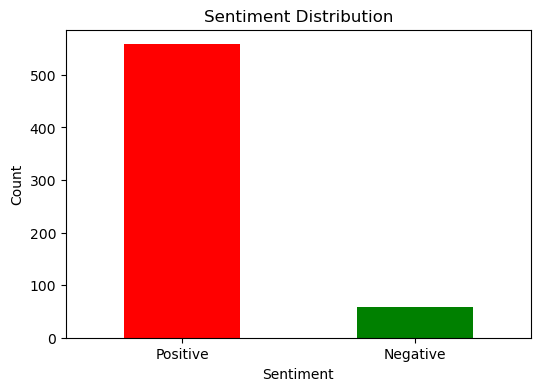

In [189]:
# Generate and display graphs
plt.figure(figsize=(6,4))
df_sentences["predicted_label"].value_counts().plot(kind='bar', color=['red', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(rotation=0)
plt.show()

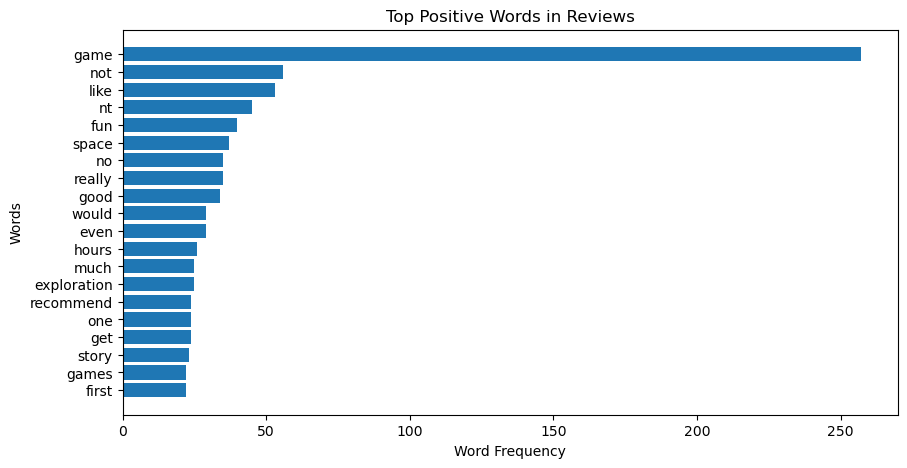

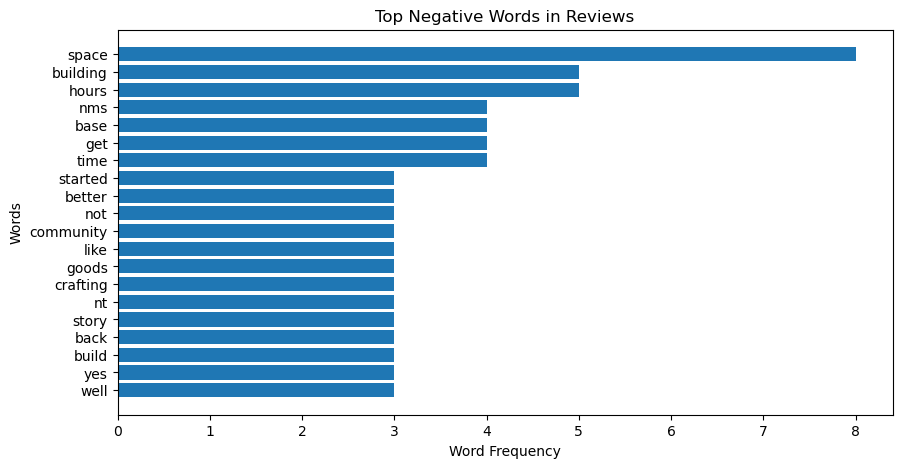

In [190]:
# Top Positive and Negative Words
positive_words = Counter(" ".join(df_sentences[df_sentences["predicted_label"] == "Positive"]["sentence"]).split()).most_common(20)
negative_words = Counter(" ".join(df_sentences[df_sentences["predicted_label"] == "Negative"]["sentence"]).split()).most_common(20)

# Plot positive words
plt.figure(figsize=(10,5))
plt.barh([word[0] for word in reversed(positive_words)], [word[1] for word in reversed(positive_words)])
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title("Top Positive Words in Reviews")
plt.show()

# Plot negative words
plt.figure(figsize=(10,5))
plt.barh([word[0] for word in reversed(negative_words)], [word[1] for word in reversed(negative_words)])
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.title("Top Negative Words in Reviews")
plt.show()